In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [52]:
#prepare datasets by combining nrmsd and cluster info with the context data
yeast_datasets = pd.read_csv('Data/yeast_datasets.csv')[['SeriesID','nrmsd','re_cluster']]
yeast_datasets.columns = ['dataset','nrmsd','re_cluster']
context_dataset = pd.read_csv('Data/yeast_dataset_context.csv')
regression_dataset = yeast_datasets.merge(context,on='dataset',how='inner')#define which of the context features to use
selected_features = ['max_periodicity','number_of_reads','5_KL','3_KL','A_site_KL','Lowest_median_base_qual','Peak_per_sequence_quality','Highest_overrepresented_sequence_frequency']
#define the subset of Datasets that cluster separately with the ref RNA dataset
exceptions = ['GSE56622','GSE100626','GSE108778','GSE115366','GSE121189']

In [56]:
#calculate the test statistics for comparisons between the "exception" and other datasets for each feature
#independent ttests with multi-sample correction (holm-sidak)
uncorrected_p = []
for feature in selected_features:
    main_set,exception_set = [],[]
    for row in range(regression_dataset.shape[0]):
        if regression_dataset['dataset'].iloc[row] in exceptions:
            exception_set.append(regression_dataset[feature].iloc[row])
        else:
            main_set.append(regression_dataset[feature].iloc[row])
    uncorrected_p.append(ttest_ind(main_set,exception_set)[1])
corrected_p = list(multipletests(uncorrected_p)[1])

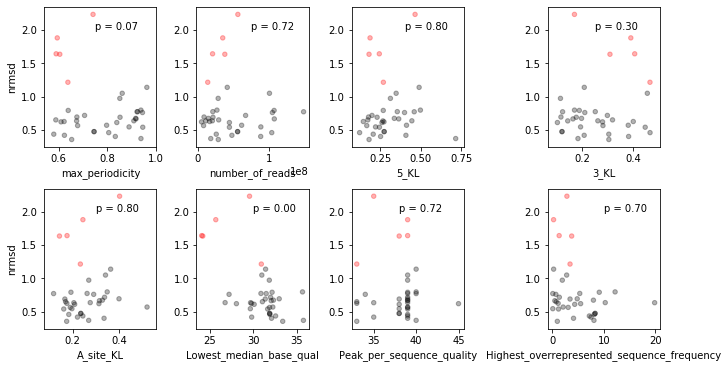

In [60]:
y_plot = regression_dataset['nrmsd']
fig,ax = plt.subplots(2,int(len(selected_features)/2),figsize=(10,5),constrained_layout=True)
label_pos = [0.75,75000000,0.4,0.25,0.3,30,38,10]
#prepare a color list to display datasets that still have high nrmsd when used with ref RNA set in red
cols = []
for dataset in regression_dataset['dataset']:
    if dataset in exceptions:
        cols.append('red')
    else:
        cols.append('black')
for feature_no in range(len(selected_features)):
    if feature_no < 4:
        row = 0
        col = feature_no
    else:
        row = 1
        col = feature_no - 4
    ax[row,col].scatter(regression_dataset[selected_features[feature_no]],y_plot,s=20,c=cols,alpha = 0.3)
    ax[row,col].set_xlabel(selected_features[feature_no])
    ax[row,col].text(label_pos[feature_no],2,'p = {:.2f}'.format(corrected_p[feature_no]))
ax[0,0].set_ylabel('nrmsd')
ax[1,0].set_ylabel('nrmsd')
#plt.savefig('Correlations.svg')
plt.show()

In [54]:
X = regression_dataset[selected_features]
y_tree = regression_dataset['re_cluster']

#construct and apply a pipeline that scales the data and fits the Extra Trees Classifier
scaler = StandardScaler()
clf = ExtraTreesClassifier(n_estimators=100,random_state=24)
cat_pipeline = make_pipeline(scaler, clf)
cat_pipeline.fit(X,y_tree)

coefs = abs(clf.feature_importances_) / sum(clf.feature_importances_  )

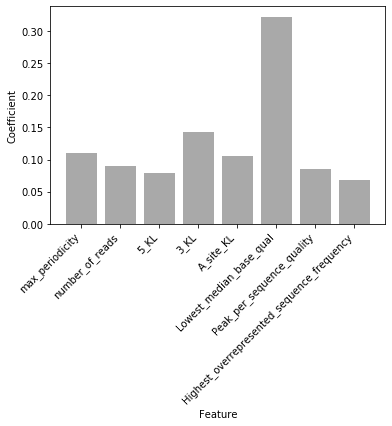

In [61]:
fig,ax = plt.subplots()
ax.bar(x=selected_features,height=coefs,color = 'darkgrey')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature')
ax.set_xticklabels(selected_features,rotation=45,horizontalalignment="right")
#plt.savefig('Pred_Coeffs.svg')
plt.show()